In [1]:
from pyspark.sql import SparkSession
import os

def create_session(app_name: str = "anomaly_detection", master: str = "local[*]"):
    jar_path = os.path.abspath("clickhouse-jdbc-0.9.1-all.jar")  # full path to your jar
    spark = (
        SparkSession.builder
        .appName(app_name)
        .master(master)
        .config("spark.jars", jar_path)  # this ensures Spark loads the jar
        .getOrCreate()
    )
    return spark


In [2]:
def read_from_clickhouse():
    spark = create_session()

    df = (
        spark.read.format("jdbc")
        .option(
            "url", 
            "jdbc:clickhouse://193.36.84.247:8123/stream_meter_db"
        )
        .option(
            "dbtable",
            """(
                SELECT *
                FROM anomaly_prediction_features
                WHERE window_start >= now() - INTERVAL 90 DAY
                ORDER BY meter_id, window_start
            ) AS t"""
        )
        .option("driver", "com.clickhouse.jdbc.ClickHouseDriver")
        .option("user", "default")
        .option("password", "")
        .load()
    )

    return df


In [3]:
df = read_from_clickhouse()

# df.show(20, truncate=False)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/30 13:56:43 WARN Utils: Your hostname, yegane, resolves to a loopback address: 127.0.1.1; using 10.73.72.234 instead (on interface wlp0s20f3)
25/11/30 13:56:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/30 13:56:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [ ]:
from pyspark.sql import functions as F, Window


def build_labels(df):
    w = Window.partitionBy("meter_id").orderBy("window_start")

    df = df.withColumn("label_spike", F.lead("spike_anomaly", 1).over(w))
    df = df.withColumn("label_low", F.lead("low_consumption", 1).over(w))
    df = df.withColumn("label_voltage", F.lead("voltage_anomaly", 1).over(w))
    df = df.withColumn("label_rare", F.lead("rare_failure", 1).over(w))

    df = df.fillna(
        0, subset=["label_spike", "label_low", "label_voltage", "label_rare"]
    )

    return df, w

In [5]:
labels_df, w = build_labels(df)
labels_df.show(20, truncate=False)

[Stage 0:>                                                          (0 + 1) / 1]

+-------------------+-------------------+--------+------------+------------+--------------+--------------+-------------+------------+-------------+---------------+---------------+-----------+---------+-------------+----------+
|window_start       |window_end         |meter_id|power_5m_avg|power_5m_std|voltage_5m_avg|voltage_5m_std|window_status|rare_failure|spike_anomaly|low_consumption|voltage_anomaly|label_spike|label_low|label_voltage|label_rare|
+-------------------+-------------------+--------+------------+------------+--------------+--------------+-------------+------------+-------------+---------------+---------------+-----------+---------+-------------+----------+
|2025-11-23 09:35:00|2025-11-23 09:40:00|1       |0.56666666  |0.1266228   |230.43333     |6.7678185     |2            |false       |true         |false          |false          |true       |false    |false        |false     |
|2025-11-23 09:40:00|2025-11-23 09:45:00|1       |0.5105085   |0.08069576  |230.78136     |5

In [6]:
def build_time_features(df):
    df = df.withColumn("hour", F.hour("window_start"))
    df = df.withColumn("day", F.dayofweek("window_start"))
    df = df.withColumn("month", F.month("window_start"))
    df = df.withColumn("year", F.year("window_start"))
    return df


def build_lag_features(df):
    lags = [1, 2, 3]
    w = Window.partitionBy("meter_id").orderBy("window_start")

    for lag in lags:
        df = df.withColumn(f"lag{lag}_power_avg", F.lag("power_5m_avg", lag).over(w))
        df = df.withColumn(f"lag{lag}_power_std", F.lag("power_5m_std", lag).over(w))
        df = df.withColumn(f"lag{lag}_voltage_avg", F.lag("voltage_5m_avg", lag).over(w))
        df = df.withColumn(f"lag{lag}_voltage_std", F.lag("voltage_5m_std", lag).over(w))

    return df


def build_delta_features(df):
    df = df.withColumn("delta_power", F.col("power_5m_avg") - F.col("lag1_power_avg"))
    df = df.withColumn(
        "delta_voltage", F.col("voltage_5m_avg") - F.col("lag1_voltage_avg")
    )
    return df


def build_features(df):
    df = build_time_features(df)
    df = build_lag_features(df)
    df = build_delta_features(df)

    df = df.dropna()
    return df

In [7]:
features_df = build_features(labels_df)
features_df.show(20, truncate=False)

25/11/30 13:57:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 3:>                                                          (0 + 1) / 1]

+-------------------+-------------------+--------+------------+------------+--------------+--------------+-------------+------------+-------------+---------------+---------------+-----------+---------+-------------+----------+----+---+-----+----+--------------+--------------+----------------+----------------+--------------+--------------+----------------+----------------+--------------+--------------+----------------+----------------+-------------+-------------+
|window_start       |window_end         |meter_id|power_5m_avg|power_5m_std|voltage_5m_avg|voltage_5m_std|window_status|rare_failure|spike_anomaly|low_consumption|voltage_anomaly|label_spike|label_low|label_voltage|label_rare|hour|day|month|year|lag1_power_avg|lag1_power_std|lag1_voltage_avg|lag1_voltage_std|lag2_power_avg|lag2_power_std|lag2_voltage_avg|lag2_voltage_std|lag3_power_avg|lag3_power_std|lag3_voltage_avg|lag3_voltage_std|delta_power  |delta_voltage|
+-------------------+-------------------+--------+------------+---

In [8]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# For Spike Anomaly

def training_data(df):
    training_df = df.select(
        "power_5m_avg",
        "power_5m_std",
        "voltage_5m_avg",
        "voltage_5m_std",
        "hour",
        "day",
        "month",
        "year",
        "lag1_power_avg",
        "lag2_power_avg",
        "lag3_power_avg",
        "lag1_voltage_avg",  # <- fixed
        "lag2_voltage_avg",  # <- fixed
        "lag3_voltage_avg",  # <- fixed
        "delta_power",
        "delta_voltage",
        "label_spike",
    )

    return training_df



In [9]:
def build_feature_vector(training_df):
    feature_cols = [c for c in training_df.columns if c != "label_spike"]

    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    return assembler



In [10]:
def build_model():
    rf = RandomForestClassifier(
        labelCol="label_spike", featuresCol="features", numTrees=200, maxDepth=10
    )

    return rf

In [11]:
from pyspark.ml import Pipeline

def build_pipeline(rf, assembler):
    pipeline = Pipeline(stages=[assembler, rf])
    return pipeline

In [12]:
def train_model(training_df):
    train, test = training_df.randomSplit([0.8, 0.2], seed=42)

    assembler = build_feature_vector(train)
    rf = build_model()
    pipeline = build_pipeline(rf, assembler)

    model = pipeline.fit(train)  # <- now this works
    predictions = model.transform(test)

    return predictions, model

In [13]:
def evaluate_model(predictions):
    evaluator = BinaryClassificationEvaluator(
        labelCol="label_spike", rawPredictionCol="prediction", metricName="areaUnderPR"
    )

    score = evaluator.evaluate(predictions)
    return score

In [14]:
training_df = training_data(features_df)
training_df.show(20)

[Stage 6:>                                                          (0 + 1) / 1]

+------------+------------+--------------+--------------+----+---+-----+----+--------------+--------------+--------------+----------------+----------------+----------------+-------------+-------------+-----------+
|power_5m_avg|power_5m_std|voltage_5m_avg|voltage_5m_std|hour|day|month|year|lag1_power_avg|lag2_power_avg|lag3_power_avg|lag1_voltage_avg|lag2_voltage_avg|lag3_voltage_avg|  delta_power|delta_voltage|label_spike|
+------------+------------+--------------+--------------+----+---+-----+----+--------------+--------------+--------------+----------------+----------------+----------------+-------------+-------------+-----------+
|   0.6014815|  0.11244499|     230.17407|      4.769744|  13|  1|   11|2025|    0.49380952|     0.5105085|    0.56666666|       230.99048|       230.78136|       230.43333|  0.107671976|  -0.81640625|      false|
|  0.78821427| 0.101654954|     229.98929|     5.0123057|  15|  1|   11|2025|     0.6014815|    0.49380952|     0.5105085|       230.17407|     

In [17]:
from pyspark.sql.functions import col, when

def train_model(training_df):
    # Fix label type
    training_df = training_df.withColumn("label_spike", col("label_spike").cast("int"))

    train, test = training_df.randomSplit([0.8, 0.2], seed=42)

    assembler = build_feature_vector(train)
    rf = build_model()
    pipeline = build_pipeline(rf, assembler)

    model = pipeline.fit(train)
    predictions = model.transform(test)

    return predictions, model


In [18]:
predictions, model = train_model(training_df)
predictions.show(20, truncate=False)


25/11/30 14:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1622.8 KiB
25/11/30 14:00:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
25/11/30 14:00:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
25/11/30 14:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1080.7 KiB
25/11/30 14:00:29 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/11/30 14:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
25/11/30 14:00:32 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
25/11/30 14:00:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/30 14:01:00 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


+------------+------------+--------------+--------------+----+---+-----+----+--------------+--------------+--------------+----------------+----------------+----------------+-------------+-------------+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------+------------------------------------------+----------+
|power_5m_avg|power_5m_std|voltage_5m_avg|voltage_5m_std|hour|day|month|year|lag1_power_avg|lag2_power_avg|lag3_power_avg|lag1_voltage_avg|lag2_voltage_avg|lag3_voltage_avg|delta_power  |delta_voltage|label_spike|features                                                                                                                                                                                                                      

In [19]:
predictions.write.parquet("spike_predictions.parquet", mode="overwrite")

25/11/30 14:01:11 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
                                                                                

In [20]:
def evaluate_model(predictions):
    evaluator = BinaryClassificationEvaluator(
        labelCol="label_spike", rawPredictionCol="prediction", metricName="areaUnderPR"
    )

    score = evaluator.evaluate(predictions)
    return score


In [21]:
score = evaluate_model(predictions)
print("AUPR:", score)


25/11/30 14:01:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


AUPR: 0.948433264948992


In [22]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.select("prediction", "label_spike") \
    .rdd.map(lambda row: (float(row.prediction), float(row.label_spike)))

metrics = MulticlassMetrics(predictionAndLabels)

print("Confusion Matrix:")
print(metrics.confusionMatrix().toArray())


/home/yegane/Documents/smart-meter-simulation/.venv/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/11/30 14:02:52 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
                                                                                

Confusion Matrix:


25/11/30 14:02:53 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
[Stage 136:>                                                        (0 + 5) / 5]

[[ 2186.  1533.]
 [  274. 28363.]]


In [23]:
print("Precision:", metrics.precision(1.0))
print("Recall:", metrics.recall(1.0))
print("F1:", metrics.fMeasure(1.0))


Precision: 0.9487222370885737
Recall: 0.990431958654887
F1: 0.9691285257888712


In [24]:
print("Precision (class 0):", metrics.precision(0.0))
print("Recall (class 0):", metrics.recall(0.0))
print("F1-score (class 0):", metrics.fMeasure(0.0))

Precision (class 0): 0.8886178861788618
Recall (class 0): 0.5877924173164829
F1-score (class 0): 0.707557857258456


In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label_spike",
    rawPredictionCol="probability"
)

auc = evaluator.evaluate(predictions)
print("AUC:", auc)


25/11/30 14:03:08 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


AUC: 0.9796162272076963


25/11/30 14:05:04 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
                                                                                

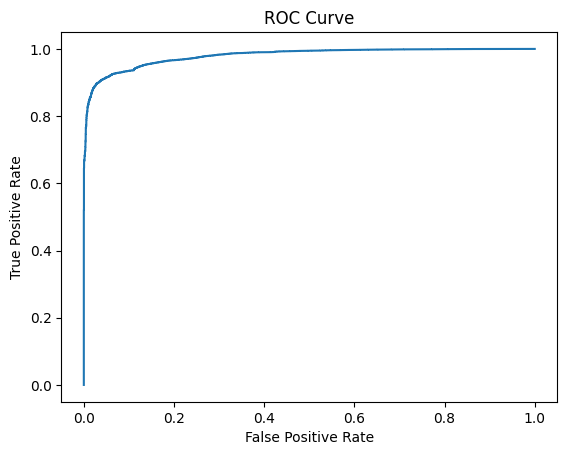

In [27]:
pdf = predictions.select("probability", "label_spike").toPandas()

probs = pdf["probability"].apply(lambda v: float(v[1]))
labels = pdf["label_spike"].astype(int)

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(labels, probs)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
